In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, confusion_matrix
from sklearn.calibration import calibration_curve
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler

import comet_ml
from comet_ml import Experiment, Artifact, ConfusionMatrix

from helper_func import *

# 0. Read dataset

In [2]:
# path_csv = r"Dataset/tidyData_fe3.csv"
path_train_csv = r"Dataset/train.csv"

In [3]:
df_train = pd.read_csv(path_train_csv)
df_train.dropna(inplace=True)
df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]
print(f"Shape of df_train: {df_train.shape}")

Shape of df_train: (295862, 23)


In [4]:
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_val: {df_val.shape}")

df_train.sample(5)

Shape of df_train: (236689, 23)
Shape of df_val: (59173, 23)


,periodTime,period,x-coordinate,y-coordinate,attackingSide,shot_distance,angle,isEmptyNet,shotType,last_event_type,coor_x_last_event,coor_y_last_event,time_last_event,distance_last_event,is_rebound,Change in shot angle,Speed,power_play_time,n_friend,n_oppose,isgoal,period_second,game_second
263981,02:35,2,-37.0,-24.0,left,57.271284,-0.432408,0,Wrist Shot,Hit,84.0,42.0,11.0,137.829605,True,-0.872250,12.529964,0,5,5,0,155,2555
290499,02:58,2,-70.0,0.0,left,19.000000,0.000000,0,Tip-In,Hit,-96.0,13.0,4.0,29.068884,True,-0.341950,7.267221,0,5,5,1,178,2578
209133,01:58,1,-45.0,-3.0,left,44.102154,-0.068076,0,Slap Shot,Faceoff,-69.0,-22.0,10.0,30.610456,True,-0.138383,3.061046,0,5,5,0,118,1318
169479,08:55,2,82.0,-5.0,right,8.602325,-0.620249,0,Wrist Shot,Stoppage,82.0,-5.0,0.0,0.000000,True,-1.056877,0.000000,0,5,5,0,535,2935
30475,17:47,3,-55.0,-28.0,left,44.045431,-0.688924,1,Wrist Shot,Faceoff,69.0,22.0,14.0,133.701159,True,-1.538749,9.550083,0,5,5,1,1067,4667


# 1. Add more feature

- In this section, we will add the new feature called `attacking_zone_shot`. This feature indicates whether the shot occurred in the attacking zone.
- We choose to analyze this feature based on the observation that the shot in the attacking zone has high chance to become a goal.
- **After analyzing**, we realize that 94.5% shot happend inside attacking zone, and 5% shot happened outside attacking zone.

In [5]:
def Is_Shot_In_Attacking_Zone(x_coordinate_shot, attacking_side):

    if str(attacking_side).lower() == "left":
        x_coordinate_net = -89
        attacking_zone_range = -25
        return x_coordinate_net <= x_coordinate_shot <= attacking_zone_range
    elif str(attacking_side).lower() == "right":
        x_coordinate_net = 89
        attacking_zone_range = 25
        return  attacking_zone_range <= x_coordinate_shot <= x_coordinate_net
    else:
        return None

In [6]:
df_train['attacking_zone_shot'] = df_train.apply(lambda x: Is_Shot_In_Attacking_Zone(x['x-coordinate'], x['attackingSide']), axis=1)
df_val['attacking_zone_shot'] = df_val.apply(lambda x: Is_Shot_In_Attacking_Zone(x['x-coordinate'], x['attackingSide']), axis=1)

# 2. Feature selection

- In this section, I will use **correlation** and **mutual information** to perform the feature selection.

### a. Correlation

- In this section, we will check the correlation value between pairs of features. If the correlation between two features are larger than specific `threshold`, we will remove it.

In [7]:
list_features = ['game_second', 'period', 'x-coordinate', 'y-coordinate', 'shot_distance', 'angle', 'isEmptyNet', 'last_event_type',\
                'coor_x_last_event', 'coor_y_last_event', 'time_last_event', 'distance_last_event', 'is_rebound',\
                 'Change in shot angle', 'Speed', 'power_play_time', 'n_friend', 'n_oppose', 'attacking_zone_shot']

labels = 'isgoal'

In [8]:
X_train = df_train[list_features]
y_train = df_train[labels]

X_val = df_val[list_features]
y_val = df_val[labels]

In [9]:
def List_High_Corr_Features(df, threshold=0.9):

    # Find numerical features
    numerical_features = df.select_dtypes(include=['int', 'float']).columns
    df = df[numerical_features]

    corr_matrix = df.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    drop_features = [column for column in upper.columns if any(upper[column] > threshold)]
    # X = X.drop(drop_features, axis=1)

    return drop_features

In [10]:
# Remove high correlation features
threshold = 0.9
drop_features = List_High_Corr_Features(X_train, threshold=threshold)
print(f"[INFO] Drop high correlation: {drop_features}")

X_train = X_train.drop(drop_features, axis=1)
X_val = X_val.drop(drop_features, axis=1)

[INFO] Drop high correlation: ['period']


### b. Mutual information

- On this section, we will use mutual information to identify the relationship between features and the target variable. 
- From practical visualization, we will choose features, whose mutual information scores are above 0.01.

In [11]:
numerical_features = X_train.select_dtypes(include=['int', 'float']).columns
categorical_features = [i for i in list(X_train.columns) if i not in numerical_features]

X_train_numerical = X_train[numerical_features]
X_train_categorical = X_train[categorical_features]

X_val_numerical = X_val[numerical_features]
X_val_categorical = X_val[categorical_features]

In [12]:
mi_selector = SelectKBest(mutual_info_classif, k='all')
mi_selector.fit(X_train_numerical, y_train)

feature_scores = mi_selector.scores_   # Get feature scores

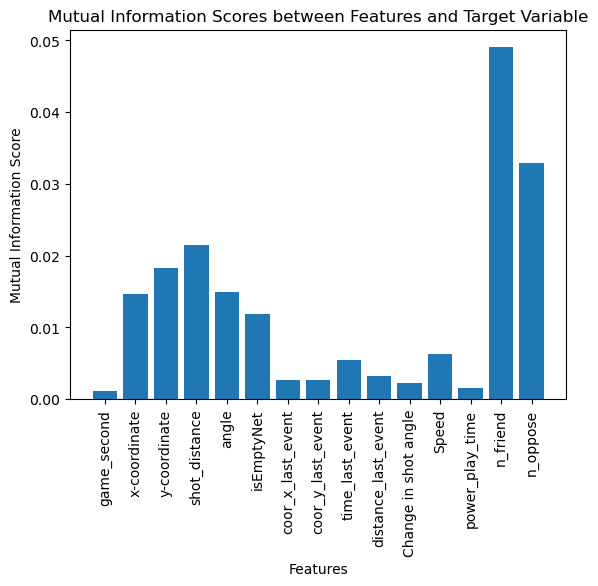

In [13]:
# Create a bar chart
plt.bar(X_train_numerical.columns, feature_scores)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores between Features and Target Variable')
plt.savefig(os.path.join('images', "best_shot_model", "mutual_information.jpg"))
plt.show()

- According to the experiment, we will set the threshold below **0.01**

In [14]:
threshold_mi = 0.01
selected_features = list(X_train_numerical.columns[mi_selector.scores_ > threshold_mi])
print(f"Selected features (mutual information): {selected_features}")

X_train_numerical = X_train_numerical[selected_features]
X_val_numerical = X_val_numerical[selected_features]

Selected features (mutual information): ['x-coordinate', 'y-coordinate', 'shot_distance', 'angle', 'isEmptyNet', 'n_friend', 'n_oppose']


In [15]:
X_train = pd.concat([X_train_numerical, X_train_categorical], axis=1)
X_val = pd.concat([X_val_numerical, X_val_categorical], axis=1)

print(f'Shape of X train: {X_train.shape}')
print(f'Shape of X val: {X_val.shape}')

Shape of X train: (236689, 10)
Shape of X val: (59173, 10)


In [16]:
list_numerical_features = list(X_train_numerical.columns)
list_categorical_features = list(X_train_categorical.columns)
print(f'Numerical features: {list_numerical_features}')
print(f'Categorical features: {list_categorical_features}')

print('-'*10)
list_features = list(X_train.columns)
print(f'List features: {list_features}')

Numerical features: ['x-coordinate', 'y-coordinate', 'shot_distance', 'angle', 'isEmptyNet', 'n_friend', 'n_oppose']
Categorical features: ['last_event_type', 'is_rebound', 'attacking_zone_shot']
----------
List features: ['x-coordinate', 'y-coordinate', 'shot_distance', 'angle', 'isEmptyNet', 'n_friend', 'n_oppose', 'last_event_type', 'is_rebound', 'attacking_zone_shot']


### e. Balance dataset

In [17]:
over_sampler = RandomOverSampler(sampling_strategy=0.3) 

X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_train_resampled))

Counter({0: 214686, 1: 22003})
Counter({0: 214686, 1: 64405})


# 3. Decision Tree

### a. Building decision tree

In [18]:
# Apply different transform to numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), list_numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(handle_unknown="ignore"), list_categorical_features)    # One-hot encode categorical features
    ],
)

In [19]:
# Parameter grid search for decision tree
param_grid_tree = {
    "tree__criterion": ['gini', 'entropy'],
    "tree__max_depth": [5, 10],
    "tree__min_samples_leaf": [5, 10]
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier())
])

In [20]:
grid_search = GridSearchCV(pipeline, param_grid_tree, cv=5, scoring='roc_auc')
# grid_search.fit(X_train, y_train)
grid_search.fit(X_train_resampled, y_train_resampled)

best_tree = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print(f"Best score: {grid_search.best_score_}")

Best Parameters: {'tree__criterion': 'entropy', 'tree__max_depth': 10, 'tree__min_samples_leaf': 5}
Best score: 0.7583225466112817


In [21]:
# Inferencing on test set
y_val_pred = best_tree.predict(X_val)
y_val_pred_proba_tree = best_tree.predict_proba(X_val)[:, 1]

# Evaluate
accuracy = accuracy_score(y_val, y_val_pred)
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba_tree)
roc_auc = auc(fpr, tpr)

conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"Accuracy validation set: {accuracy:.2f}")
print(f'ROC: {roc_auc}')
print("Confusion Matrix:")
print(conf_matrix)    

Accuracy validation set: 0.91
ROC: 0.7380561327815166
Confusion Matrix:
[[53206   535]
 [ 5002   430]]


In [22]:
path_output_tree_model = os.path.join("models", "decision_tree.pkl")
joblib.dump(best_tree, path_output_tree_model)

['models/decision_tree.pkl']

### b. Save decision tree to Comet

In [23]:
experiment = Experiment(api_key = os.environ.get('COMET_API_KEY'),\
                        project_name = os.environ.get('project_name'),\
                        workspace =  os.environ.get('workspace_name'))

metrics = {"acc": accuracy, 'roc': roc_auc}
experiment.log_metrics(metrics)
experiment.log_parameters(grid_search.best_params_)
experiment.log_model("decision_tree", path_output_tree_model)
experiment.add_tag("best_shot_model")

cm = ConfusionMatrix()
cm.compute_matrix(y_val.to_numpy(), y_val_pred)
experiment.log_confusion_matrix(matrix=cm)

experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-b09-project/ift6758-project-milestone2/83727e0afe4349d4a4737346576dda9b

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-b09-project/ift6758-project-milestone2/83727e0afe4349d4a4737346576dda9b
COMET INFO:   Metrics:
COMET INFO:     acc : 0.906426917682051
COMET INFO:     roc : 0.7380561327815166
COMET INFO:   Parameters

# 4. Logistic regression

In [24]:
# Parameter grid search for logistic regression
param_grid_linear = {
    "linear_clf__penalty": ['l1', 'l2'],
    "linear_clf__C": [0.1, 0.01]
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('linear_clf', LogisticRegression())
])

In [25]:
grid_search = GridSearchCV(pipeline, param_grid_linear, cv=5, scoring='roc_auc')

# grid_search.fit(X_train, y_train)
grid_search.fit(X_train_resampled, y_train_resampled)

best_linear_clf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print(f"Best score: {grid_search.best_score_}")

Best Parameters: {'linear_clf__C': 0.1, 'linear_clf__penalty': 'l2'}
Best score: 0.737341396113693


In [26]:
# Inferencing on test set
y_val_pred = best_linear_clf.predict(X_val)
y_val_pred_proba_tree = best_linear_clf.predict_proba(X_val)[:, 1]

# Evaluate
accuracy = accuracy_score(y_val, y_val_pred)
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba_tree)
roc_auc = auc(fpr, tpr)

conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"Accuracy validation set: {accuracy:.2f}")
print(f'ROC: {roc_auc}')
print("Confusion Matrix:")
print(conf_matrix)    

Accuracy validation set: 0.90
ROC: 0.7309586279597347
Confusion Matrix:
[[53111   630]
 [ 4999   433]]


In [27]:
path_output_linear_clf = os.path.join("models", "linear_clf.pkl")
joblib.dump(best_linear_clf, path_output_linear_clf)

['models/linear_clf.pkl']

### b. Save logistic regression to comet

In [28]:
experiment = Experiment(api_key = os.environ.get('COMET_API_KEY'),\
                        project_name = os.environ.get('project_name'),\
                        workspace =  os.environ.get('workspace_name'))

metrics = {"acc": accuracy, 'roc': roc_auc}
experiment.log_metrics(metrics)
experiment.log_parameters(grid_search.best_params_)
experiment.log_model("logistic_advanced", path_output_linear_clf)
experiment.add_tag("best_shot_model")

cm = ConfusionMatrix()
cm.compute_matrix(y_val.to_numpy(), y_val_pred)
experiment.log_confusion_matrix(matrix=cm)

experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-b09-project/ift6758-project-milestone2/320660a897ce44dcac000f3f7dd867ef

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-b09-project/ift6758-project-milestone2/320660a897ce44dcac000f3f7dd867ef
COMET INFO:   Metrics:
COMET INFO:     acc : 0.9048721545299376
COMET INFO:     roc : 0.7309586279597347
COMET INFO:   Parameter

# 5. Visualization

In [29]:
y_val_pred_proba_tree = best_tree.predict_proba(X_val)[:, 1]
y_val_pred_proba_logistic = best_linear_clf.predict_proba(X_val)[:, 1]

models = ['decision tree', 'logistic regression']
probs = [y_val_pred_proba_tree, y_val_pred_proba_logistic]

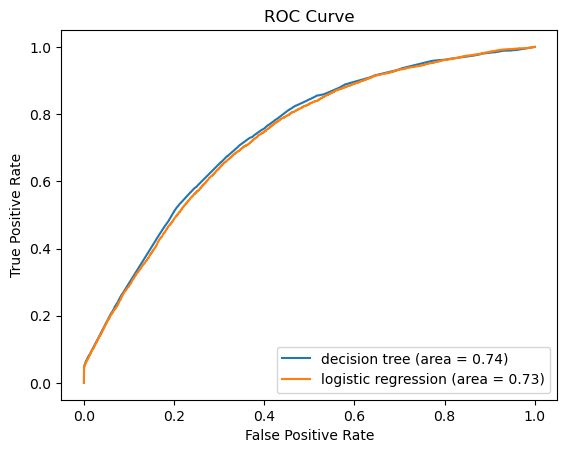

In [30]:
path_output_image = os.path.join("images", "best_shot_model", "roc.jpg")
Visualize_ROC(models, probs, y_val, path_output_image)

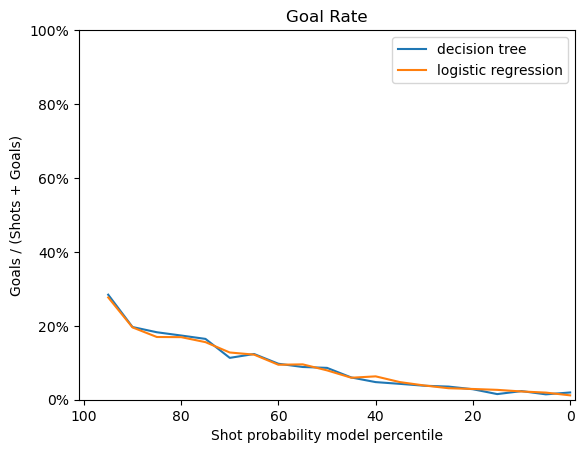

In [31]:
path_output_image = os.path.join("images", "best_shot_model", "goal_rate.jpg")
Visualize_Goal_Rate(models, probs, y_val, path_output_image)

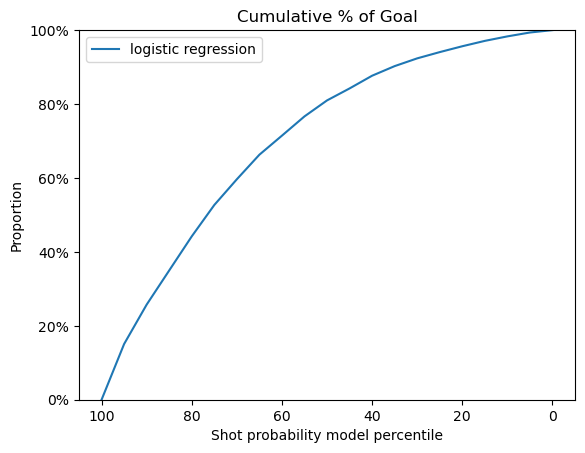

In [32]:
path_output_image = os.path.join("images", "best_shot_model", "cumulative_proportion.jpg")
Visualize_Cumulative_Proportion(models, probs, y_val, path_output_image)

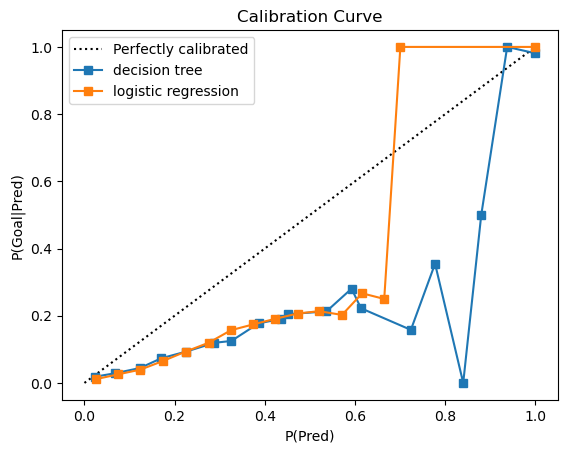

In [33]:
path_output_image = os.path.join("images", "best_shot_model", "calibration.jpg")
Visualize_Calibration(models, probs, y_val, path_output_image)